LangGraph支持创建并行、延迟和条件分支，这取决于你具体的业务场景，配合Send方法可以实现高阶的操作。

# 并行分支

节点的并行执行对于加快整体图（graph）的运行速度至关重要。LangGraph 提供了对节点并行执行的原生支持，这可以显著提升基于图的工作流的性能。这种并行化是通过扇出（fan-out）和扇入（fan-in）机制来实现的。

> 🌟 扇出和扇入机制的生活化比喻：快递分拣中心

想象你是一个快递包裹（代表一个任务）：

- 扇出（Fan-out）：
    你的包裹到达分拣中心后，被拆成多个子任务——比如要同时通知仓库发货、通知客服登记、通知物流安排车辆。
    → 1 个输入 → N 个并行操作
- 扇入（Fan-in）：
    当仓库、客服、物流都完成各自的任务后，系统会等待所有结果回来，再把它们汇总成一条“订单已处理”的最终状态。
    → N 个输出 → 1 个汇总结果
    
这就是典型的 “先发散，再聚合” 模式。

In [ ]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    aggregate: Annotated[list, operator.add]

def a(state: State):
    print(f'Adding "A" to {state["aggregate"]}')
    return {"aggregate": ["A"]}

def b(state: State):
    print(f'Adding "B" to {state["aggregate"]}')
    return {"aggregate": ["B"]}

def c(state: State):
    print(f'Adding "C" to {state["aggregate"]}')
    return {"aggregate": ["C"]}

def d(state: State):
    print(f'Adding "D" to {state["aggregate"]}')
    return {"aggregate": ["D"]}

builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)
builder.add_node(c)
builder.add_node(d)
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

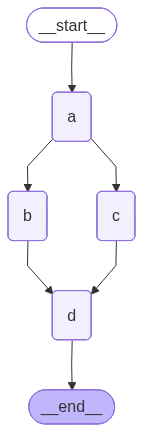

In [3]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

在上述示例中，节点"b"和"c"会在同一个超步（superstep）中并发执行。由于它们处于同一执行步骤中，LangGraph 会自动阻塞，直到所有上游节点都返回结果、也就是节点"b"和"c"都完成之后，才调用节点"d"

# 延迟节点

延迟节点执行在以下场景中非常有用：当你希望直到所有其他待处理的任务都已完成后才执行某个节点。这在分支长度不一致时尤为重要，例如在 map-reduce 类型的工作流中就非常常见。

> “Map-Reduce 类型的工作流”是一种经典的并行计算模式，最初由 Google 提出，用于高效处理大规模数据。Map阶段，任务映射/分发成N个子任务，Reduce阶段，所有任务都完成后，由汇总节点完成最终的输出。

通过给节点添加defer=True，即可实现节点的延迟执行。

In [4]:
import operator
from typing import Annotated, Any
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    aggregate: Annotated[list, operator.add]

def a(state: State):
    print(f'Adding "A" to {state["aggregate"]}')
    return {"aggregate": ["A"]}

def b(state: State):
    print(f'Adding "B" to {state["aggregate"]}')
    return {"aggregate": ["B"]}

def b_2(state: State):
    print(f'Adding "B_2" to {state["aggregate"]}')
    return {"aggregate": ["B_2"]}

def c(state: State):
    print(f'Adding "C" to {state["aggregate"]}')
    return {"aggregate": ["C"]}

def d(state: State):
    print(f'Adding "D" to {state["aggregate"]}')
    return {"aggregate": ["D"]}

builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)
builder.add_node(b_2)
builder.add_node(c)
builder.add_node(d, defer=True)  
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b_2")
builder.add_edge("b_2", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

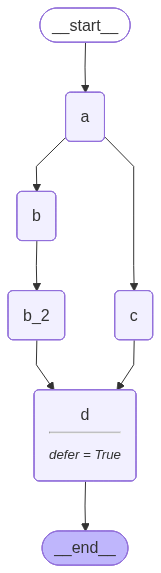

In [5]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

# 条件分支

利用上小节讲到的条件边，我们可以很轻松给你地创建条件分支。

In [6]:
import operator
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

# 定义状态类
class State(TypedDict):
    # 定义一个聚合列表，使用 operator.add 作为归约器（用于累加列表）
    aggregate: Annotated[list, operator.add]
    # 在状态中添加一个键。我们将设置这个键来决定
    # 接下来的分支走向。
    which: str

# 节点函数 A
def a(state: State):
    print(f'向 {state["aggregate"]} 添加 "A"')
    # 返回更新：向 aggregate 添加 "A"，并将 which 设置为 "c"
    return {"aggregate": ["A"], "which": "c"}  

# 节点函数 B
def b(state: State):
    print(f'向 {state["aggregate"]} 添加 "B"')
    return {"aggregate": ["B"]}

# 节点函数 C
def c(state: State):
    print(f'向 {state["aggregate"]} 添加 "C"')
    return {"aggregate": ["C"]}

# 创建状态图构建器
builder = StateGraph(State)

# 添加节点
builder.add_node(a)
builder.add_node(b)
builder.add_node(c)

# 添加普通边（固定流向）
builder.add_edge(START, "a") # 开始 -> a
builder.add_edge("b", END)  # b -> 结束
builder.add_edge("c", END)  # c -> 结束

# 定义条件边函数
def conditional_edge(state: State) -> Literal["b", "c"]:
    # 在此处填充任意逻辑，使用状态
    # 来确定下一个节点
    return state["which"] # 实际是"c"，也就是想要路由到的节点的名称

# 添加条件边：从节点 "a" 出发，根据 conditional_edge 函数的返回值决定流向
builder.add_conditional_edges("a", conditional_edge)  

# 编译图
graph = builder.compile()

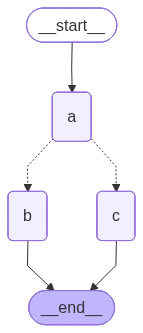

In [7]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

# Send对象

在 map-reduce 工作模式下，我们可能无法提前确定map阶段边的数量，并且下游节点所需的输入状态也可能各不相同（每个生成的对象对应一个独立的状态），因此传统的静态图结构很难满足这种需求。为了支持这种设计模式，LangGraph 允许在`条件边（conditional edges）`的`路由函数`中返回 Send 对象。Send对象接收两个参数：
1. 要调用的目标节点名称；
2. 传递给该节点的具体状态（State）。

通过这种方式，你可以在运行时动态地派发多个`并行任务`，每个任务携带各自独立的状态，并共享图状态中的一个支持追加的键（比如`Annotated[list, operator.add]`类型的键），从而灵活实现 Map-Reduce 等高级控制流。


> Send方法第二个参数所传递的键可以不在全局State schema中，这种情况下，该键是作为“局部输入”自动合并到OverallState中传递给被调用节点，但也仅限于该次 Send调用所触发的执行上下文内，不会永久改变 OverallState 的 schema，也不会影响其他并行分支或后续主流程的状态结构，简单理解的话可以把它当成函数的一个参数。

In [ ]:
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send
from typing_extensions import TypedDict, Annotated
import operator

# 定义整体状态
class OverallState(TypedDict):
    topic: str
    subjects: list[str]
    jokes: Annotated[list[str], operator.add]  # 使用 add 归约器来累加笑话列表
    best_selected_joke: str

# 节点函数：生成话题
def generate_topics(state: OverallState):
    # 返回三个动物主题
    return {"subjects": ["lions", "elephants", "penguins"]}

# 节点函数：生成笑话
def generate_joke(state: OverallState):
    # 根据主题映射生成对应的笑话
    joke_map = {
        "lions": "为什么狮子不喜欢快餐？因为它们追不上啊！",
        "elephants": "为什么大象不用电脑？因为它们害怕老鼠！",
        "penguins": "为什么企鹅不喜欢在派对上和陌生人聊天？因为它们觉得很难打破僵局（也有‘破冰’之意）"
    }
    # 注意：这里使用 state["subject"]，说明传入的 state 中必须包含 "subject" 键
    return {"jokes": [joke_map[state["subject"]]]}

# 条件边函数：决定流向
def continue_to_jokes(state: OverallState):
    # 使用 Send API 为每个主题创建一个发送指令
    # 这将触发 "generate_joke" 节点多次执行（并发）
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]

# 节点函数：选择最佳笑话
def best_joke(state: OverallState):
    # 这里简单地硬编码选择企鹅相关的笑话
    return {"best_selected_joke": "penguins"}

# 构建状态图
builder = StateGraph(OverallState)

# 添加节点
builder.add_node("generate_topics", generate_topics)
builder.add_node("generate_joke", generate_joke)
builder.add_node("best_joke", best_joke)

# 添加边
builder.add_edge(START, "generate_topics") # 开始 -> 生成话题

# 从 "generate_topics" 出发，根据 continue_to_jokes 函数的返回值进行分支
# 这里指定了 target 是 "generate_joke"，意味着所有 Send 指令都会指向该节点
builder.add_conditional_edges("generate_topics", continue_to_jokes, ["generate_joke"])

# "generate_joke" -> "best_joke"
builder.add_edge("generate_joke", "best_joke")

# "best_joke" -> 结束
builder.add_edge("best_joke", END)

# 编译图
graph = builder.compile()

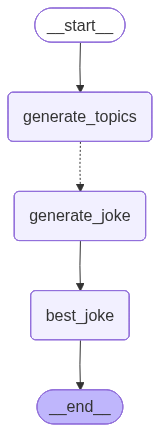

In [3]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

上面的builder.add_conditional_edges("generate_topics", continue_to_jokes, ["generate_joke"])第三个参数是个列表，是一种简化写法，仅在满足以下所有条件时才有效：
1. 路由函数返回的值本身就是图中已存在的节点名称（而不是逻辑标签）；
2. 你提供的列表恰好是所有可能返回的节点名的全集。

在这种情况下，LangGraph 会把这个列表自动转换成一个恒等映射字典，["generate_joke"] 会被内部转为 {"generate_joke": "generate_joke"}。但是为了代码的健壮性，<span style='color:red'>**建议还是显式地提供一个完整的映射字典，而不是依赖这个简化写法**</span>。